# 模式识别作业 11.15  
**陆承镪 SA17011050**


## TOC:
* [数据读入](#数据读入)
* [K-means](#K-means)
   * [超参数影响](#超参数影响)
   * [外部标签对比](#外部标签对比)
* [谱聚类](#谱聚类)
   * [超参影响](#超参影响)
   * [外部标签比较](#外部标签比较)
   


In [55]:
import sklearn
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import Counter
from collections import defaultdict

import matplotlib.cm as cm
import matplotlib.pyplot as plt


In [49]:
data_path = './EEG data/EEG_feature.txt'
emotion_path = './EEG data/EEG_emotion_category.txt'
valence_path = './EEG data/valence_arousal_label.txt'
subject_path = './EEG data/subject_video.txt'

## 数据读入
首先读入数据以及各类标签。简单地看一下标签的分布，emotion的9类分布不太均匀，而愉悦度和唤醒度的样例分布较为均匀。   

In [53]:
def read_labels():
    emotion_label, valence, arousal, tester, video = defaultdict(), defaultdict(), defaultdict(), defaultdict(), defaultdict()
    for line, content in enumerate(codecs.open(emotion_path)):
        emotion_label[line] = int(content.strip())
    for line, content in enumerate(codecs.open(valence_path)):
        valence[line] = int(content.strip().split('\t')[0])
        arousal[line] = int(content.strip().split('\t')[1])
    for line, content in enumerate(codecs.open(valence_path)):
        tester[line] = int(content.strip().split('\t')[0])
        video[line] = int(content.strip().split('\t')[1])
    return emotion_label, valence, arousal, tester, video
    
data = pd.read_csv(data_path, sep='\t', header=None)
emotion_label, valence, arousal, tester, video = read_labels()
reduced_data = PCA(n_components=2).fit_transform(data)
print("Distribution of emotion: ",Counter(emotion_label.values()))
print("Distribution of valence: ",Counter(valence.values()))
print("Distribution of arousal: ",Counter(arousal.values()))

Distribution of emotion:  Counter({0: 111, 11: 101, 4: 85, 5: 67, 2: 55, 3: 39, 12: 35, 6: 25, 1: 15})
Distribution of valence:  Counter({1: 289, 2: 244})
Distribution of arousal:  Counter({1: 268, 2: 265})


## K-means
我们选取K-means作为第一个聚类算法，这里我们需要选择一个超参数，也就是聚类数目。考虑到我们的数据是有标签的，其中emotion标签为9类，subject_video中标签分别是27和20类，而愉悦度和唤醒度分别都是2类。由于数据规模较小，使用27和20类显然无法达到较好的性能，这里我们在比较时仅考虑三类标签，也就是emotion，valence和arousal。  

### 超参数影响
下面我们使用Silhouette分析来看`n_cluster`对算法的影响，这里超参数的范围从2取到10，囊括了我们需要考虑对比的三类标签的数目。  
值得一提的是，我们这里使用了 **k-means++**来减轻初始化的随机性对算法的稳定性造成的破坏。  


For n_cluster =  2 The average silhouette_score is : 0.248572960529


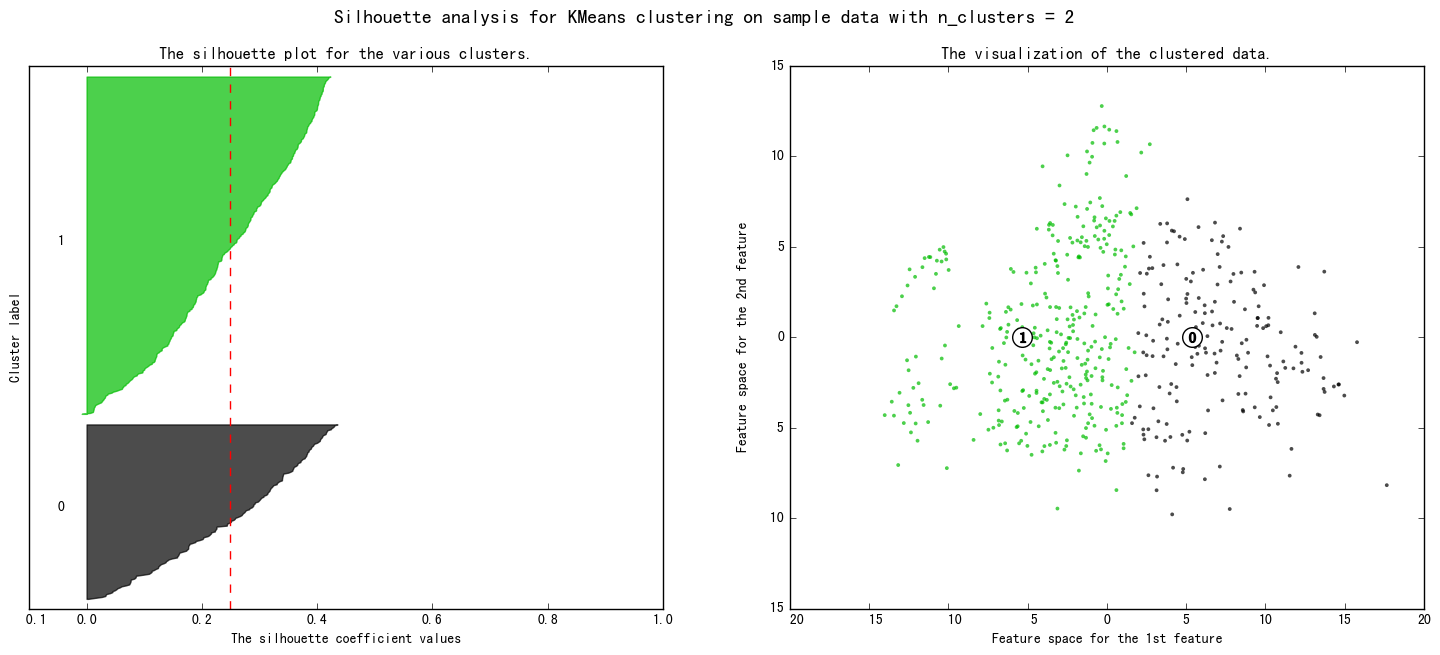

For n_cluster =  3 The average silhouette_score is : 0.229714431731


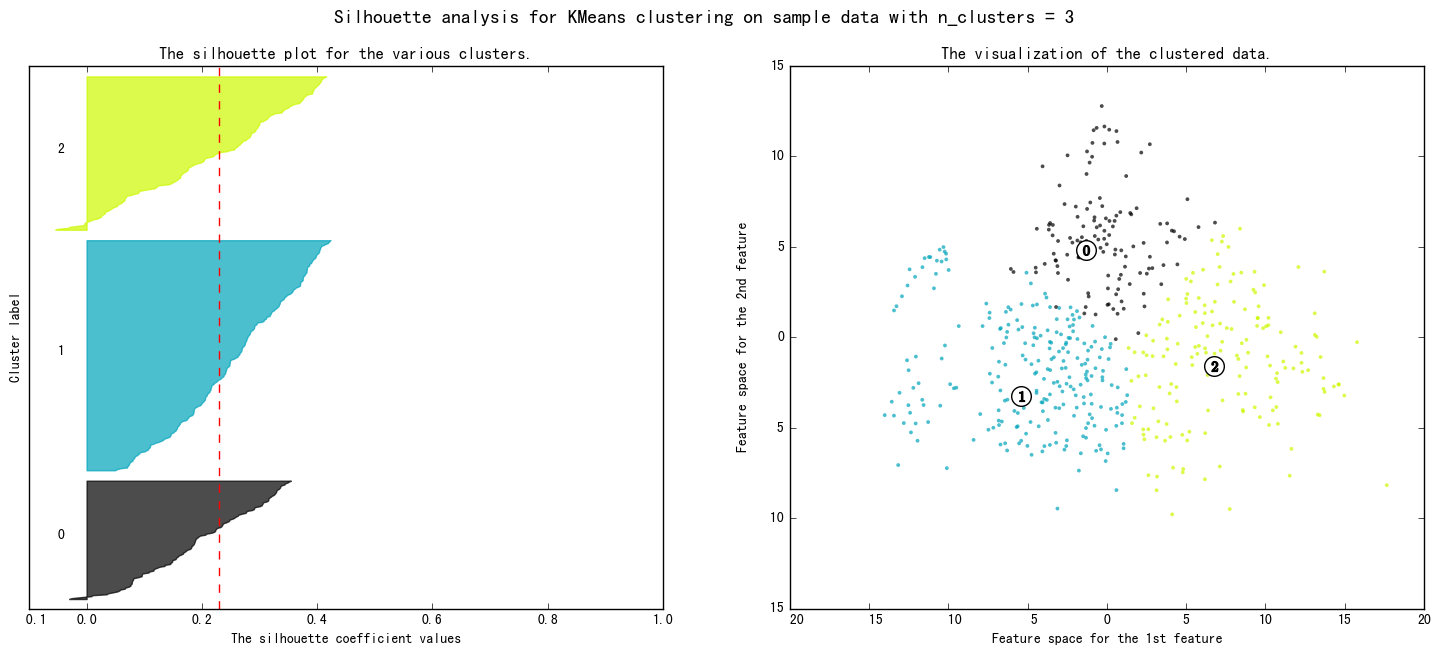

For n_cluster =  5 The average silhouette_score is : 0.23333926429


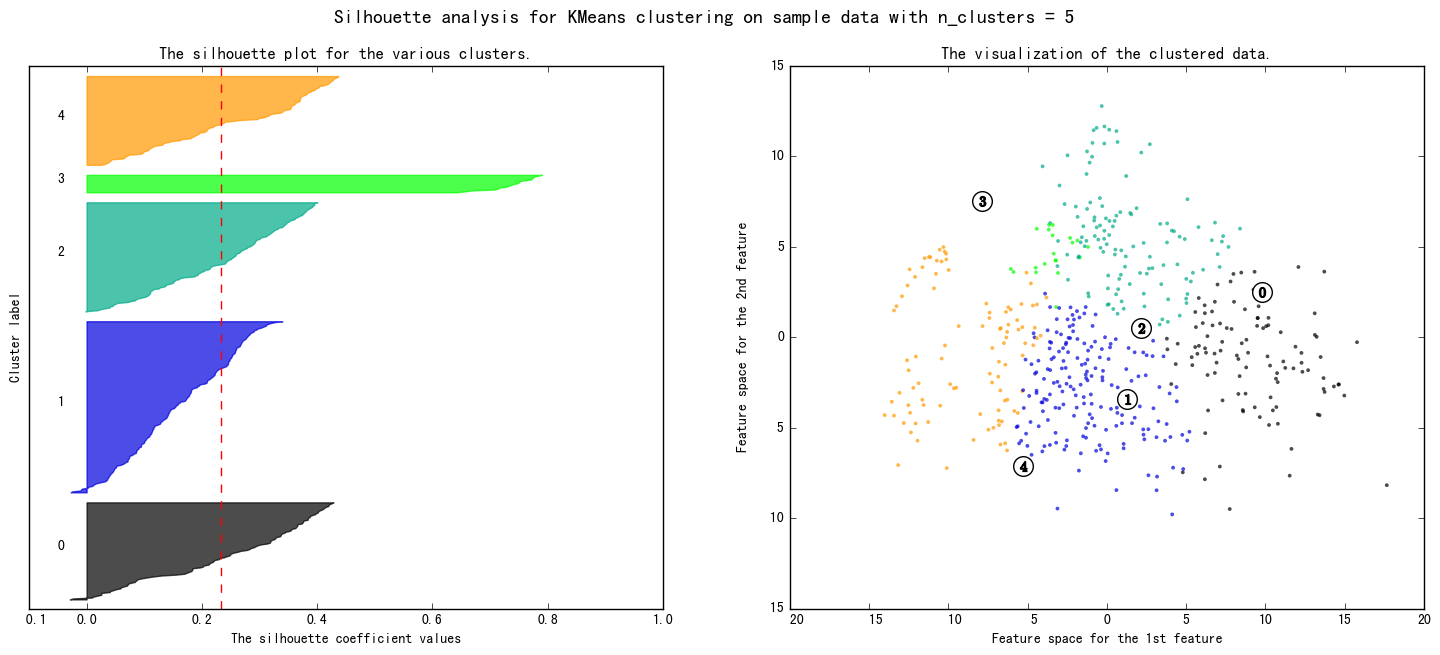

For n_cluster =  9 The average silhouette_score is : 0.21055220781


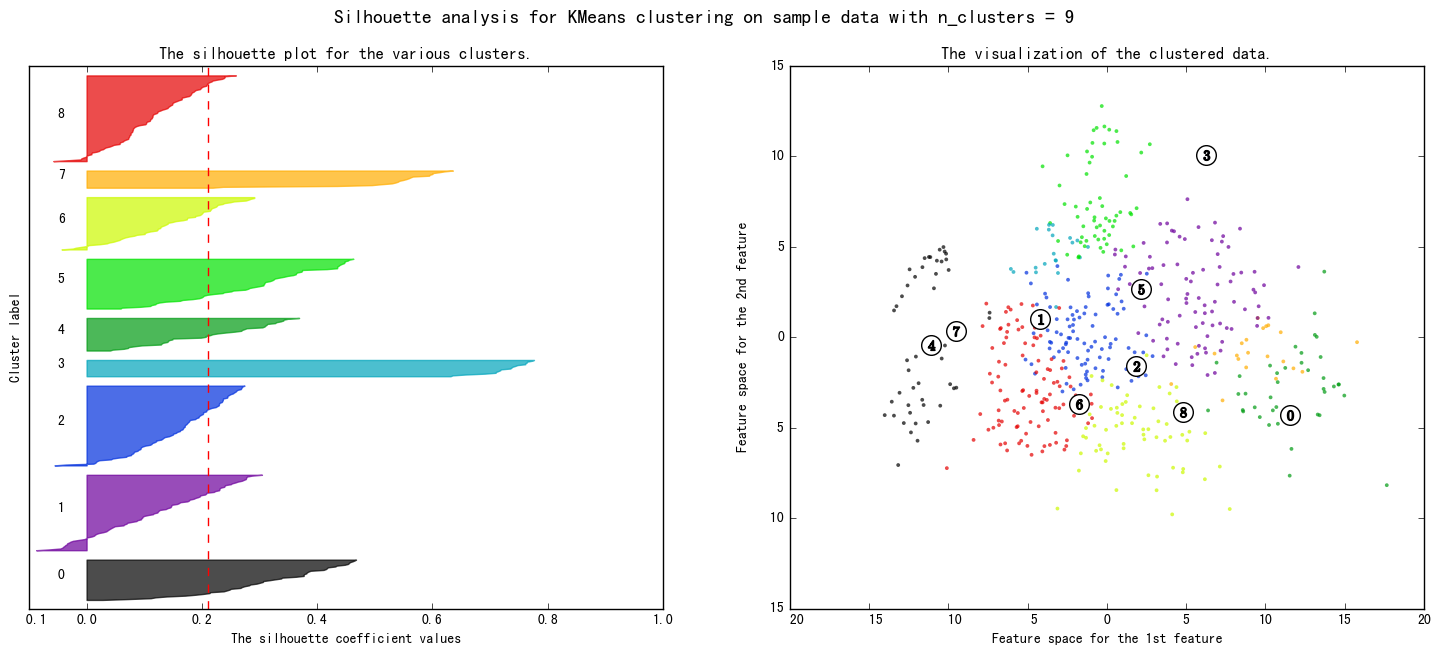

For n_cluster =  10 The average silhouette_score is : 0.213117565111


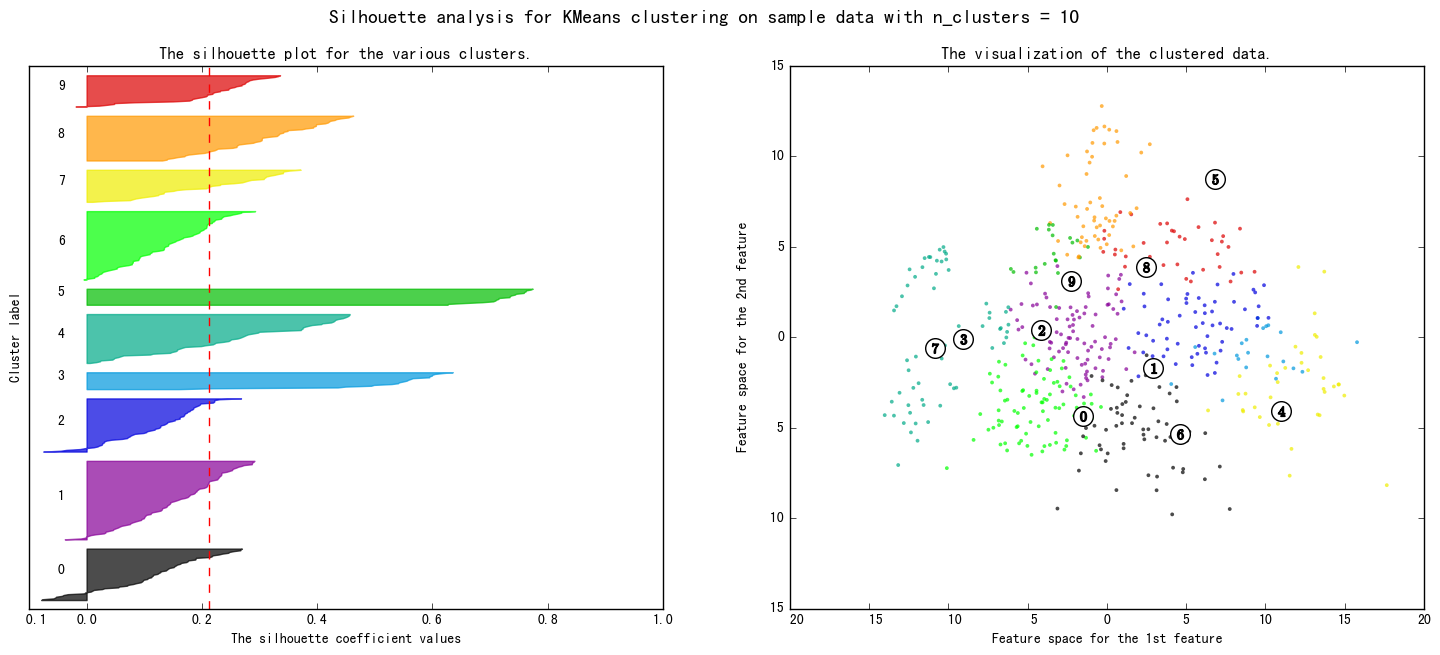

In [22]:
random_state = 16
range_n_clusters = [2, 3, 5, 9, 10]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    
    estimator = KMeans(n_clusters=n_clusters, init='k-means++', random_state=random_state)
    cluster_labels = estimator.fit_predict(data)
    
    silhouette_avg = silhouette_score(data, cluster_labels)
    print("For n_cluster = ", n_clusters,
         "The average silhouette_score is :", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
        
    X = PCA(n_components=2).fit_transform(data)
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = PCA(n_components=2).fit_transform(estimator.cluster_centers_)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

从图中以及Silhouette数值可以看出，算法在该数据集上当聚类数设置为2时，是比较合理的，当聚类数设置过大时，往往没有办法得到好的聚类结果，这一点从PCA降维后的着色图上就可以看出。  
因此我们下面就将设置`n_clusters`为2，然后将聚类结果和两个二类的label相比较。  


### 外部标签对比

In [43]:
print('label\t  tinertia\thomo\tcompl\tv-meas\tARI\tAMI')


def bench_k_means(estimator, name, data, labels):
    estimator.fit(data)
    print('%-8s\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             ))
for name, label in [('valence', valence), ('arousal', arousal)]:
    bench_k_means(KMeans(n_clusters=2, init='k-means++'), name=name, data=data, labels=list(label.values()))
    

label	  tinertia	homo	compl	v-meas	ARI	AMI
valence 	37047	0.000	0.000	0.000	-0.002	-0.001
arousal 	37040	0.004	0.004	0.004	0.003	0.003


我们这里使用了几个常见的指标来判断聚类效果，包括homogeneity score，completeness score，V measure， adjusted Rand index和adjusted mutual information
从上面可以看出，算法的聚类结果相对而言拟合arousal的效果更好，但是总体来说，如果将其作为监督的算法来说，聚类效果并不理想。下面我们将结果可视化，看下效果。  

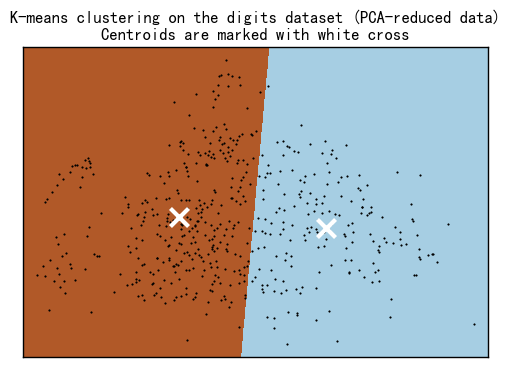

In [46]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=2)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

降维后来看，这样的聚类结果还是有一定意义，但是显然，如果使用外部标签指标来看，该结果和其中任何一个的拟合度都不高。 

## 谱聚类
### 超参影响
我们的第二个算法选择谱聚类，我们知道，谱聚类比较适用于数据分布较为均匀的情况，所以其实我们可以预想到, 算法对类别数大于2时的处理不会很理想. 但是我们还是来逐个试试,看下超参数的影响.  
这里我们还测试了一个谱聚类中重要的超参数，也就是`assign_labels`，我们可以取`kmeans`或者`discretize`，一般来说，前者效果更好但是后者稳定性更高。


In [60]:
for n_clusters in [2,3,5,6,7,8,9,10]:
    for assign_labels in ['kmeans', 'discretize']:
        estimator = SpectralClustering(n_clusters=n_clusters, random_state=random_state, assign_labels=assign_labels)
        cluster_labels = estimator.fit_predict(data)
    
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("n_cluster=", n_clusters, "assign label=%9s"%(assign_labels),
             "average silhouette_score=", silhouette_avg)

n_cluster= 2 assign label=   kmeans average silhouette_score= 0.123660201127
n_cluster= 2 assign label=discretize average silhouette_score= 0.068434535097
n_cluster= 3 assign label=   kmeans average silhouette_score= 0.0573057846013
n_cluster= 3 assign label=discretize average silhouette_score= 0.0105968594168
n_cluster= 5 assign label=   kmeans average silhouette_score= -0.00266233859293
n_cluster= 5 assign label=discretize average silhouette_score= -0.0541422024373
n_cluster= 6 assign label=   kmeans average silhouette_score= -0.10472790324
n_cluster= 6 assign label=discretize average silhouette_score= 0.0383333747024
n_cluster= 7 assign label=   kmeans average silhouette_score= -0.0810068491715
n_cluster= 7 assign label=discretize average silhouette_score= 0.0176418900318
n_cluster= 8 assign label=   kmeans average silhouette_score= -0.133476838133
n_cluster= 8 assign label=discretize average silhouette_score= 0.00807948618833
n_cluster= 9 assign label=   kmeans average silhouette_s

从上面我们可以看出来，结果基本符合预期，当我们取`n_clusters`为2，`assign_label`为kmeans时分数最高。  

## 外部标签比较

In [65]:
print('label\thomo\tcompl\tv-meas\tARI\tAMI')


def bench_k_means(estimator, name, data, labels):
    estimator.fit(data)
    print('%-4s\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, 
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             ))
for name, label in [('valence', valence), ('arousal', arousal)]:
    bench_k_means(SpectralClustering(n_clusters=n_clusters, random_state=random_state, assign_labels='kmeans'), name=name, data=data, labels=list(label.values()))
    

label	homo	compl	v-meas	ARI	AMI
valence	0.005	0.005	0.005	-0.002	-0.009
arousal	0.036	0.041	0.038	0.001	0.022


可以看出，相比较于Kmeans算法，谱聚类在内部指标上效果显得较弱，但是与外部标签对比，谱聚类的效果更好，特别是在和唤醒度的指标相比时。  